# Workshop 2: Handwritten digit classification with PyTorch
In this workshop we will learn how to train a neural network with images 
as input to classify hand-written digits
([info of the data](http://yann.lecun.com/exdb/mnist/)). The main blocks of the workshop are:

1. Get the data from PyTorch repository and visualize it.
2. Pre-process the data.
3. Design the network.
4. Train the network.
5. Evaluate the model.

# 1. Get the data from PyTorch repository and visualize it.

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set random seed for reproducibility
torch.manual_seed(42)

In [3]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 73106707.14it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 37352973.74it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25746770.05it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13093146.92it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [5]:
train_dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F459370EE60>, 5)

In [6]:
train_dataset[0][0].show()

In [7]:
sample_array = np.array(train_dataset[0][0])
print("Sample shape:", sample_array.shape)
print("Sample min value:", sample_array.min())
print("Sample max value:", sample_array.max())

Sample shape: (28, 28)
Sample min value: 0
Sample max value: 255


In [8]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [9]:
test_dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F44D1251EA0>, 7)

In [10]:
test_dataset[0][0].show()

# 2. Pre-process the data.

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# Split the test set into validation and test sets
valid_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [5000, 5000])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)#Shuffle significa que entre epochs va barajando los datos para no pasarselos en el mismo orden y aprenda de ello. 
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
images, labels = next(iter(train_loader)) #Lo convertimos en un iterable de Python
print("Sample shape:", images.shape) #Sale el 1 porque es que es en blanco y negro. 
print("Sample min value:", images.min())
print("Sample max value:", images.max())

Sample shape: torch.Size([64, 1, 28, 28])
Sample min value: tensor(0.)
Sample max value: tensor(1.)


In [13]:
# Import dependence for visualization of images
plt.rcParams['figure.figsize'] = (10,10)  # Configure figure size for 
                                          # appropriate visualization

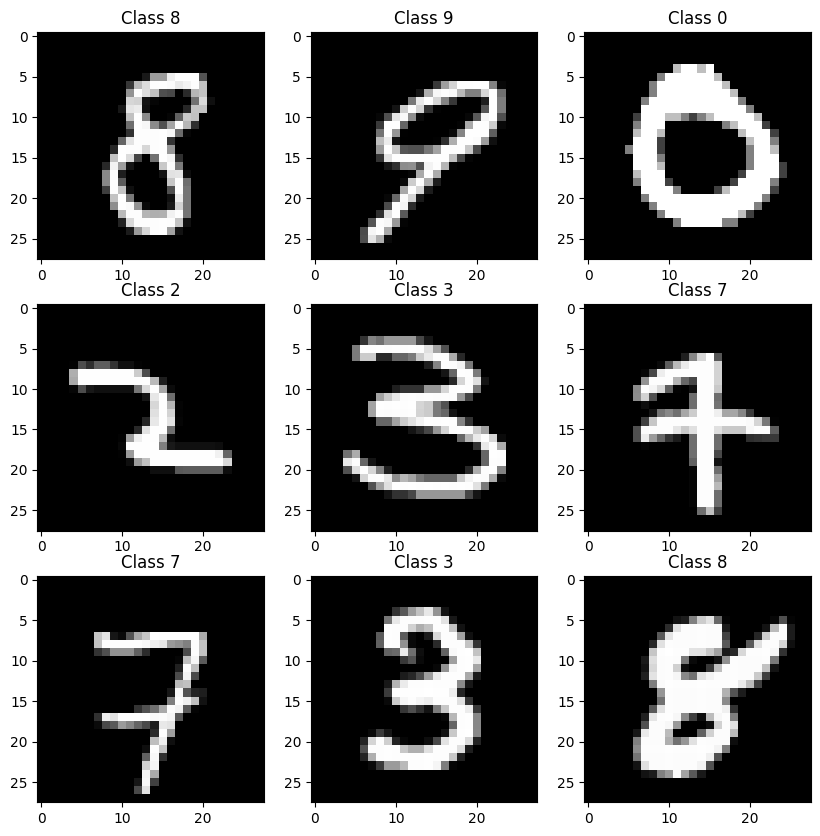

In [14]:
# Plot the images in a 3x3 grid
nrows = 3
ncols = 3
nsamples = nrows*ncols
for i in range(nsamples):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i, 0, :, :], cmap='gray', interpolation='none')
    plt.title("Class {}".format(labels[i]))

# 3. Design the network.

In [15]:
# Define model

#En pytorch nuestra red neuronal va a ser una clase. 

class Net(nn.Module):
    def __init__(self):  # Declaramos las capas que va a tener la red
        super(Net, self).__init__()  # Esto siempre igual
        self.fc1 = nn.Linear(784, 32) # Linear es una capa que esta totalmente conectada. A cada capa le decimos cuantas variables va atener a la salida y cuantas neuronas va a tener en la capa oculta
        self.fc2 = nn.Linear(32, 10)  #Aqui la capa de entrada es 32 porque la capa de salida de la neurona anterior era 32. Tiene 10 neuronas de salida porque tenemos 10 capas. 

    def forward(self, x): #Aqui vamos a definir como unas capas se conectan con otras
        x = x.view(-1, 784) #Hace un reshape a la capa de entrada. -1 es la dimension del batch. se queda tal cual. La segunda dimension en 784 porque es el size de los pixeles en fila
        x = torch.relu(self.fc1(x)) #Aplica relu en la primera capa
        x = torch.softmax(self.fc2(x), dim=1) #Aplica softmax en la segunda
        return x

model = Net()

In [17]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]          25,120
            Linear-2                   [-1, 10]             330
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.10
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [18]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 4. Train the network.

In [19]:
def get_accuracy(y_pred, y_true):
    """Calculate the accuracy between predicted and true labels"""
    _, y_pred = torch.max(y_pred, dim=1)
    correct = torch.sum(y_pred == y_true).float()
    acc = correct / len(y_true)
    return acc

In [20]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Le indicamos el dispositivo. Cuda es el software funciona sobre las GPU de Nvidia. 
model.to(device)

train_loss_history = []
valid_loss_history = []
train_accuracy_history = []
valid_accuracy_history = []

num_epochs = 10

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): #En batches de 64 me va pasando todo el train_loader

        # Clear gradients
        optimizer.zero_grad() 

        # Move images and labels to device
        # Pasamos imagenes y etiquetas a la GPU. 
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        # Generamos las predicciones de entrenamiento de las imagenes para cada batch de 64
        outputs = model(images)

        # Compute loss
        # Ahora vemos como lo ha hecho el modelo y vemos el loss. 
        loss = criterion(outputs, labels)

        # Backward pass
        # Calculamos los gradientes para cada uno de los pesos
        loss.backward()

        # Update weights en consecuencia de los gradientes
        optimizer.step()

    # Calculate accuracy
    train_loss = 0
    valid_loss = 0
    train_accuracy = 0
    valid_accuracy = 0

# A partir de aqui a la red neuronal no le pasa nada. Esto es informacion para nosotros. La red aprende con lo de arriba

    # Turn off gradients for validation to speed up inference
    with torch.no_grad(): 
        for images, labels in train_loader: # Hacemos un bucle para los datos de training y otro para los de validacion

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            output = model(images)

            # Calculate loss
            train_loss += criterion(output, labels)

            # Calculate accuracy
            train_accuracy += get_accuracy(output, labels)
        
        train_loss_history.append(train_loss.cpu().numpy() / len(train_loader)) # Vamos haciendo un append a la lista que hemos creado arriba
        train_accuracy_history.append(train_accuracy.cpu().numpy() / len(train_loader))

        for images, labels in valid_loader: #Aquí el bucle para validación

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            output = model(images)

            # Calculate loss
            valid_loss += criterion(output, labels)

            # Calculate accuracy
            valid_accuracy += get_accuracy(output, labels)
        
        valid_loss_history.append(valid_loss.cpu().numpy() / len(valid_loader))
        valid_accuracy_history.append(valid_accuracy.cpu().numpy() / len(valid_loader))

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train loss: {train_loss/len(train_loader):.3f} | "
              f"Train accuracy: {train_accuracy/len(train_loader):.3f} | "
              f"Valid loss: {valid_loss/len(valid_loader):.3f} | "
              f"Valid accuracy: {valid_accuracy/len(valid_loader):.3f}")

Epoch 1/10 | Train loss: 1.559 | Train accuracy: 0.918 | Valid loss: 1.552 | Valid accuracy: 0.922
Epoch 2/10 | Train loss: 1.543 | Train accuracy: 0.928 | Valid loss: 1.536 | Valid accuracy: 0.934
Epoch 3/10 | Train loss: 1.534 | Train accuracy: 0.935 | Valid loss: 1.528 | Valid accuracy: 0.941
Epoch 4/10 | Train loss: 1.527 | Train accuracy: 0.942 | Valid loss: 1.524 | Valid accuracy: 0.944
Epoch 5/10 | Train loss: 1.521 | Train accuracy: 0.946 | Valid loss: 1.520 | Valid accuracy: 0.946
Epoch 6/10 | Train loss: 1.517 | Train accuracy: 0.949 | Valid loss: 1.517 | Valid accuracy: 0.950
Epoch 7/10 | Train loss: 1.514 | Train accuracy: 0.953 | Valid loss: 1.514 | Valid accuracy: 0.950
Epoch 8/10 | Train loss: 1.512 | Train accuracy: 0.953 | Valid loss: 1.514 | Valid accuracy: 0.951
Epoch 9/10 | Train loss: 1.508 | Train accuracy: 0.957 | Valid loss: 1.513 | Valid accuracy: 0.951
Epoch 10/10 | Train loss: 1.505 | Train accuracy: 0.959 | Valid loss: 1.510 | Valid accuracy: 0.955


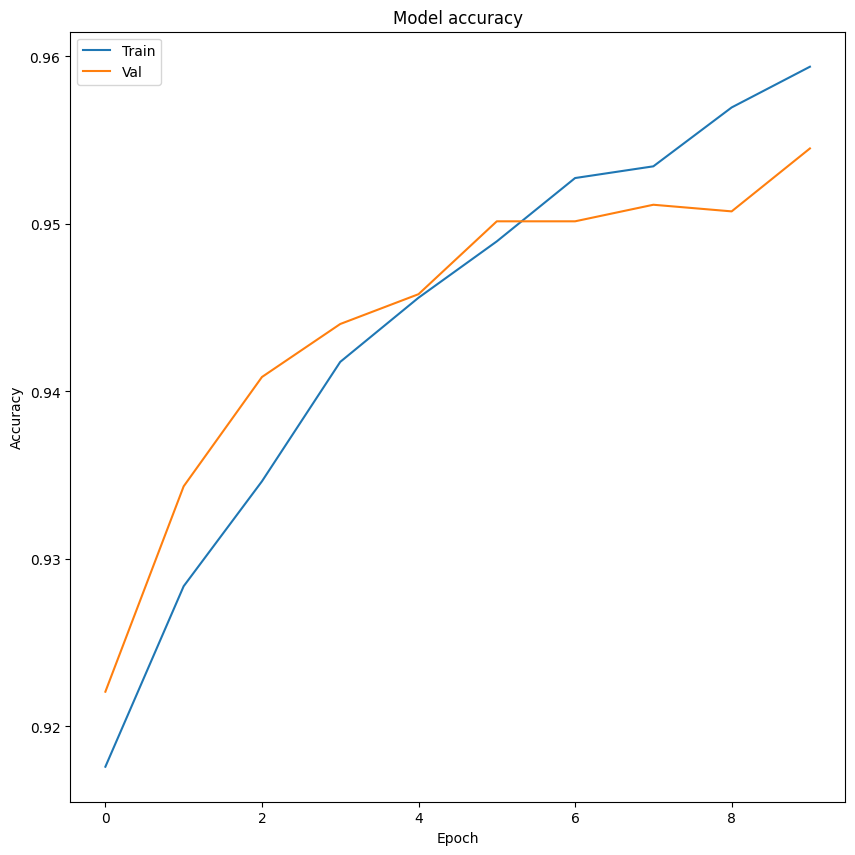

In [21]:
# Plot training and validation accuracy
plt.plot(train_accuracy_history)
plt.plot(valid_accuracy_history)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

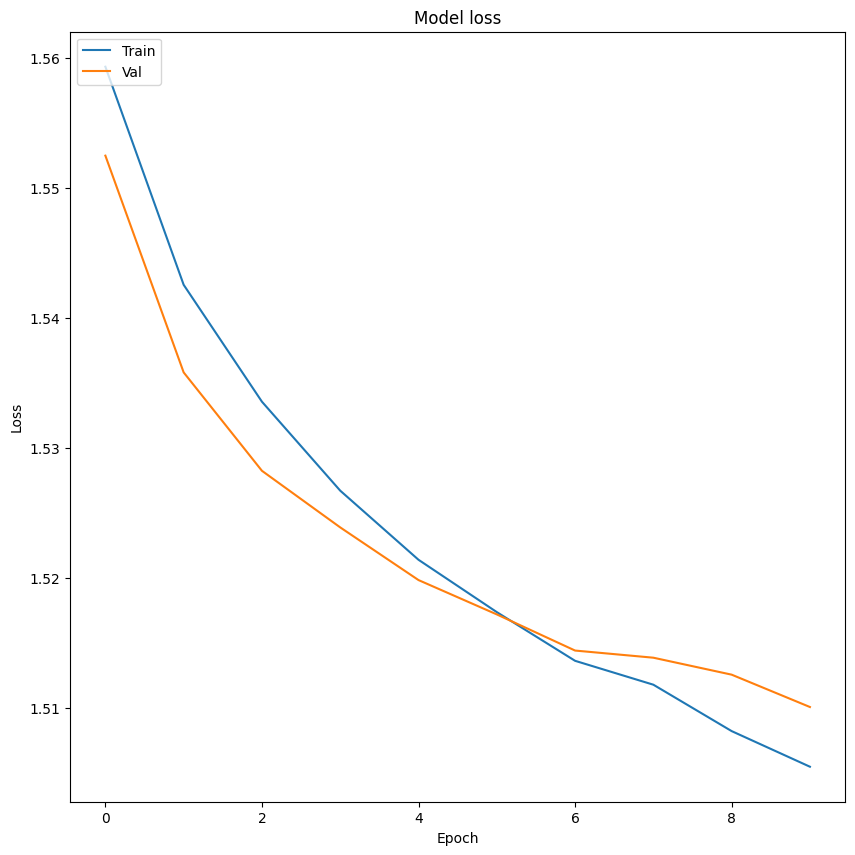

In [22]:
# Plot training and validation accuracy
plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# 5. Evaluate the model.

In [23]:
# Calculate metrics in the test partition
test_loss = 0
test_accuracy = 0
for images, labels in test_loader:

    # Move images and labels to device
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass
    output = model(images)

    # Calculate loss
    test_loss += criterion(output, labels)

    # Calculate accuracy
    test_accuracy += get_accuracy(output, labels)
print("Test loss:", test_loss / len(test_loader))
print("Test accuracy:", test_accuracy / len(test_loader))

Test loss: tensor(1.5199, grad_fn=<DivBackward0>)
Test accuracy: tensor(0.9422)


# Exercise 1: Create a new model with 512 neurons in the hidden layer and repeat the process

In [24]:
# Design the model

class Net(nn.Module):
    def __init__(self):  # Declaramos las capas que va a tener la red
        super(Net, self).__init__()  # Esto siempre igual
        self.fc1 = nn.Linear(784, 512) # Linear es una capa que esta totalmente conectada. A cada capa le decimos cuantas variables va atener a la salida y cuantas neuronas va a tener en la capa oculta
        self.fc2 = nn.Linear(512, 10)  #Aqui la capa de entrada es 32 porque la capa de salida de la neurona anterior era 32. Tiene 10 neuronas de salida porque tenemos 10 capas. 

    def forward(self, x): #Aqui vamos a definir como unas capas se conectan con otras
        x = x.view(-1, 784) #Hace un reshape a la capa de entrada. -1 es la dimension del batch. se queda tal cual. La segunda dimension en 784 porque es el size de los pixeles en fila
        x = torch.relu(self.fc1(x)) #Aplica relu en la primera capa
        x = torch.softmax(self.fc2(x), dim=1) #Aplica softmax en la segunda
        return x

model = Net()

In [25]:
# Show summary of the model
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                   [-1, 10]           5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.55
Estimated Total Size (MB): 1.56
----------------------------------------------------------------


In [26]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
# Train the model
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Le indicamos el dispositivo. Cuda es el software funciona sobre las GPU de Nvidia. 
model.to(device)

train_loss_history = []
valid_loss_history = []
train_accuracy_history = []
valid_accuracy_history = []

num_epochs = 10

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): #En batches de 64 me va pasando todo el train_loader

        # Clear gradients
        optimizer.zero_grad() 

        # Move images and labels to device
        # Pasamos imagenes y etiquetas a la GPU. 
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        # Generamos las predicciones de entrenamiento de las imagenes para cada batch de 64
        outputs = model(images)

        # Compute loss
        # Ahora vemos como lo ha hecho el modelo y vemos el loss. 
        loss = criterion(outputs, labels)

        # Backward pass
        # Calculamos los gradientes para cada uno de los pesos
        loss.backward()

        # Update weights en consecuencia de los gradientes
        optimizer.step()

    # Calculate accuracy
    train_loss = 0
    valid_loss = 0
    train_accuracy = 0
    valid_accuracy = 0

# A partir de aqui a la red neuronal no le pasa nada. Esto es informacion para nosotros. La red aprende con lo de arriba

    # Turn off gradients for validation to speed up inference
    with torch.no_grad(): 
        for images, labels in train_loader: # Hacemos un bucle para los datos de training y otro para los de validacion

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            output = model(images)

            # Calculate loss
            train_loss += criterion(output, labels)

            # Calculate accuracy
            train_accuracy += get_accuracy(output, labels)
        
        train_loss_history.append(train_loss.cpu().numpy() / len(train_loader)) # Vamos haciendo un append a la lista que hemos creado arriba
        train_accuracy_history.append(train_accuracy.cpu().numpy() / len(train_loader))

        for images, labels in valid_loader: #Aquí el bucle para validación

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            output = model(images)

            # Calculate loss
            valid_loss += criterion(output, labels)

            # Calculate accuracy
            valid_accuracy += get_accuracy(output, labels)
        
        valid_loss_history.append(valid_loss.cpu().numpy() / len(valid_loader))
        valid_accuracy_history.append(valid_accuracy.cpu().numpy() / len(valid_loader))

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train loss: {train_loss/len(train_loader):.3f} | "
              f"Train accuracy: {train_accuracy/len(train_loader):.3f} | "
              f"Valid loss: {valid_loss/len(valid_loader):.3f} | "
              f"Valid accuracy: {valid_accuracy/len(valid_loader):.3f}")

Epoch 1/10 | Train loss: 1.523 | Train accuracy: 0.945 | Valid loss: 1.521 | Valid accuracy: 0.946
Epoch 2/10 | Train loss: 1.504 | Train accuracy: 0.962 | Valid loss: 1.502 | Valid accuracy: 0.962
Epoch 3/10 | Train loss: 1.492 | Train accuracy: 0.973 | Valid loss: 1.494 | Valid accuracy: 0.970
Epoch 4/10 | Train loss: 1.488 | Train accuracy: 0.976 | Valid loss: 1.491 | Valid accuracy: 0.971
Epoch 5/10 | Train loss: 1.482 | Train accuracy: 0.982 | Valid loss: 1.487 | Valid accuracy: 0.977
Epoch 6/10 | Train loss: 1.480 | Train accuracy: 0.984 | Valid loss: 1.488 | Valid accuracy: 0.975
Epoch 7/10 | Train loss: 1.476 | Train accuracy: 0.987 | Valid loss: 1.483 | Valid accuracy: 0.979
Epoch 8/10 | Train loss: 1.473 | Train accuracy: 0.989 | Valid loss: 1.482 | Valid accuracy: 0.980
Epoch 9/10 | Train loss: 1.479 | Train accuracy: 0.984 | Valid loss: 1.490 | Valid accuracy: 0.973
Epoch 10/10 | Train loss: 1.472 | Train accuracy: 0.990 | Valid loss: 1.481 | Valid accuracy: 0.981


In [28]:
# Obtain metrics in the test partition
test_loss = 0
test_accuracy = 0
for images, labels in test_loader:

    # Move images and labels to device
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass
    output = model(images)

    # Calculate loss
    test_loss += criterion(output, labels)

    # Calculate accuracy
    test_accuracy += get_accuracy(output, labels)
print("Test loss:", test_loss / len(test_loader))
print("Test accuracy:", test_accuracy / len(test_loader))

Test loss: tensor(1.4863, grad_fn=<DivBackward0>)
Test accuracy: tensor(0.9753)


# Exercise 2: Add a hidden layer with 512 neurons to the model of exercise 1 and repeat the process

In [29]:
# Design the model

class Net(nn.Module):
    def __init__(self):  # Declaramos las capas que va a tener la red
        super(Net, self).__init__()  # Esto siempre igual
        self.fc1 = nn.Linear(784, 512) # Linear es una capa que esta totalmente conectada. A cada capa le decimos cuantas variables va atener a la salida y cuantas neuronas va a tener en la capa oculta
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)  #Aqui la capa de entrada es 32 porque la capa de salida de la neurona anterior era 32. Tiene 10 neuronas de salida porque tenemos 10 capas. 

    def forward(self, x): #Aqui vamos a definir como unas capas se conectan con otras
        x = x.view(-1, 784) #Hace un reshape a la capa de entrada. -1 es la dimension del batch. se queda tal cual. La segunda dimension en 784 porque es el size de los pixeles en fila
        x = torch.relu(self.fc1(x)) #Aplica relu en la primera capa
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1) #Aplica softmax en la segunda
        return x

model = Net()

In [30]:
# Show summary of the model
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                  [-1, 512]         262,656
            Linear-3                   [-1, 10]           5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.55
Estimated Total Size (MB): 2.57
----------------------------------------------------------------


In [31]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
# Train the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Le indicamos el dispositivo. Cuda es el software funciona sobre las GPU de Nvidia. 
model.to(device)

train_loss_history = []
valid_loss_history = []
train_accuracy_history = []
valid_accuracy_history = []

num_epochs = 10

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): #En batches de 64 me va pasando todo el train_loader

        # Clear gradients
        optimizer.zero_grad() 

        # Move images and labels to device
        # Pasamos imagenes y etiquetas a la GPU. 
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        # Generamos las predicciones de entrenamiento de las imagenes para cada batch de 64
        outputs = model(images)

        # Compute loss
        # Ahora vemos como lo ha hecho el modelo y vemos el loss. 
        loss = criterion(outputs, labels)

        # Backward pass
        # Calculamos los gradientes para cada uno de los pesos
        loss.backward()

        # Update weights en consecuencia de los gradientes
        optimizer.step()

    # Calculate accuracy
    train_loss = 0
    valid_loss = 0
    train_accuracy = 0
    valid_accuracy = 0

# A partir de aqui a la red neuronal no le pasa nada. Esto es informacion para nosotros. La red aprende con lo de arriba

    # Turn off gradients for validation to speed up inference
    with torch.no_grad(): 
        for images, labels in train_loader: # Hacemos un bucle para los datos de training y otro para los de validacion

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            output = model(images)

            # Calculate loss
            train_loss += criterion(output, labels)

            # Calculate accuracy
            train_accuracy += get_accuracy(output, labels)
        
        train_loss_history.append(train_loss.cpu().numpy() / len(train_loader)) # Vamos haciendo un append a la lista que hemos creado arriba
        train_accuracy_history.append(train_accuracy.cpu().numpy() / len(train_loader))

        for images, labels in valid_loader: #Aquí el bucle para validación

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            output = model(images)

            # Calculate loss
            valid_loss += criterion(output, labels)

            # Calculate accuracy
            valid_accuracy += get_accuracy(output, labels)
        
        valid_loss_history.append(valid_loss.cpu().numpy() / len(valid_loader))
        valid_accuracy_history.append(valid_accuracy.cpu().numpy() / len(valid_loader))

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train loss: {train_loss/len(train_loader):.3f} | "
              f"Train accuracy: {train_accuracy/len(train_loader):.3f} | "
              f"Valid loss: {valid_loss/len(valid_loader):.3f} | "
              f"Valid accuracy: {valid_accuracy/len(valid_loader):.3f}")

Epoch 1/10 | Train loss: 1.515 | Train accuracy: 0.948 | Valid loss: 1.510 | Valid accuracy: 0.953
Epoch 2/10 | Train loss: 1.498 | Train accuracy: 0.964 | Valid loss: 1.498 | Valid accuracy: 0.963
Epoch 3/10 | Train loss: 1.491 | Train accuracy: 0.970 | Valid loss: 1.495 | Valid accuracy: 0.966
Epoch 4/10 | Train loss: 1.493 | Train accuracy: 0.969 | Valid loss: 1.494 | Valid accuracy: 0.968
Epoch 5/10 | Train loss: 1.488 | Train accuracy: 0.973 | Valid loss: 1.491 | Valid accuracy: 0.969
Epoch 6/10 | Train loss: 1.487 | Train accuracy: 0.974 | Valid loss: 1.491 | Valid accuracy: 0.971
Epoch 7/10 | Train loss: 1.486 | Train accuracy: 0.975 | Valid loss: 1.490 | Valid accuracy: 0.971
Epoch 8/10 | Train loss: 1.486 | Train accuracy: 0.975 | Valid loss: 1.488 | Valid accuracy: 0.974
Epoch 9/10 | Train loss: 1.480 | Train accuracy: 0.982 | Valid loss: 1.486 | Valid accuracy: 0.975
Epoch 10/10 | Train loss: 1.479 | Train accuracy: 0.982 | Valid loss: 1.483 | Valid accuracy: 0.978


In [33]:
# Obtain metrics in the test partition
test_loss = 0
test_accuracy = 0
for images, labels in test_loader:

    # Move images and labels to device
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass
    output = model(images)

    # Calculate loss
    test_loss += criterion(output, labels)

    # Calculate accuracy
    test_accuracy += get_accuracy(output, labels)
print("Test loss:", test_loss / len(test_loader))
print("Test accuracy:", test_accuracy / len(test_loader))

Test loss: tensor(1.4899, grad_fn=<DivBackward0>)
Test accuracy: tensor(0.9717)


# Exercise 3: Add 20 epochs to the model of exercise 1 and repeat the process

In [34]:
# Design the model

class Net(nn.Module):
    def __init__(self):  # Declaramos las capas que va a tener la red
        super(Net, self).__init__()  # Esto siempre igual
        self.fc1 = nn.Linear(784, 512) # Linear es una capa que esta totalmente conectada. A cada capa le decimos cuantas variables va atener a la salida y cuantas neuronas va a tener en la capa oculta
        self.fc2 = nn.Linear(512, 10)  #Aqui la capa de entrada es 32 porque la capa de salida de la neurona anterior era 32. Tiene 10 neuronas de salida porque tenemos 10 capas. 

    def forward(self, x): #Aqui vamos a definir como unas capas se conectan con otras
        x = x.view(-1, 784) #Hace un reshape a la capa de entrada. -1 es la dimension del batch. se queda tal cual. La segunda dimension en 784 porque es el size de los pixeles en fila
        x = torch.relu(self.fc1(x)) #Aplica relu en la primera capa
        x = torch.softmax(self.fc2(x), dim=1) #Aplica softmax en la segunda
        return x

model = Net()

In [35]:
# Show summary of the model
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                   [-1, 10]           5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.55
Estimated Total Size (MB): 1.56
----------------------------------------------------------------


In [36]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
# Train the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Le indicamos el dispositivo. Cuda es el software funciona sobre las GPU de Nvidia. 
model.to(device)

train_loss_history = []
valid_loss_history = []
train_accuracy_history = []
valid_accuracy_history = []

num_epochs = 20

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader): #En batches de 64 me va pasando todo el train_loader

        # Clear gradients
        optimizer.zero_grad() 

        # Move images and labels to device
        # Pasamos imagenes y etiquetas a la GPU. 
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        # Generamos las predicciones de entrenamiento de las imagenes para cada batch de 64
        outputs = model(images)

        # Compute loss
        # Ahora vemos como lo ha hecho el modelo y vemos el loss. 
        loss = criterion(outputs, labels)

        # Backward pass
        # Calculamos los gradientes para cada uno de los pesos
        loss.backward()

        # Update weights en consecuencia de los gradientes
        optimizer.step()

    # Calculate accuracy
    train_loss = 0
    valid_loss = 0
    train_accuracy = 0
    valid_accuracy = 0

# A partir de aqui a la red neuronal no le pasa nada. Esto es informacion para nosotros. La red aprende con lo de arriba

    # Turn off gradients for validation to speed up inference
    with torch.no_grad(): 
        for images, labels in train_loader: # Hacemos un bucle para los datos de training y otro para los de validacion

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            output = model(images)

            # Calculate loss
            train_loss += criterion(output, labels)

            # Calculate accuracy
            train_accuracy += get_accuracy(output, labels)
        
        train_loss_history.append(train_loss.cpu().numpy() / len(train_loader)) # Vamos haciendo un append a la lista que hemos creado arriba
        train_accuracy_history.append(train_accuracy.cpu().numpy() / len(train_loader))

        for images, labels in valid_loader: #Aquí el bucle para validación

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            output = model(images)

            # Calculate loss
            valid_loss += criterion(output, labels)

            # Calculate accuracy
            valid_accuracy += get_accuracy(output, labels)
        
        valid_loss_history.append(valid_loss.cpu().numpy() / len(valid_loader))
        valid_accuracy_history.append(valid_accuracy.cpu().numpy() / len(valid_loader))

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train loss: {train_loss/len(train_loader):.3f} | "
              f"Train accuracy: {train_accuracy/len(train_loader):.3f} | "
              f"Valid loss: {valid_loss/len(valid_loader):.3f} | "
              f"Valid accuracy: {valid_accuracy/len(valid_loader):.3f}")

Epoch 1/20 | Train loss: 1.522 | Train accuracy: 0.944 | Valid loss: 1.517 | Valid accuracy: 0.951
Epoch 2/20 | Train loss: 1.501 | Train accuracy: 0.964 | Valid loss: 1.503 | Valid accuracy: 0.961
Epoch 3/20 | Train loss: 1.490 | Train accuracy: 0.973 | Valid loss: 1.493 | Valid accuracy: 0.972
Epoch 4/20 | Train loss: 1.486 | Train accuracy: 0.977 | Valid loss: 1.491 | Valid accuracy: 0.972
Epoch 5/20 | Train loss: 1.485 | Train accuracy: 0.978 | Valid loss: 1.491 | Valid accuracy: 0.972
Epoch 6/20 | Train loss: 1.479 | Train accuracy: 0.984 | Valid loss: 1.484 | Valid accuracy: 0.980
Epoch 7/20 | Train loss: 1.476 | Train accuracy: 0.986 | Valid loss: 1.484 | Valid accuracy: 0.978
Epoch 8/20 | Train loss: 1.474 | Train accuracy: 0.988 | Valid loss: 1.481 | Valid accuracy: 0.981
Epoch 9/20 | Train loss: 1.473 | Train accuracy: 0.989 | Valid loss: 1.482 | Valid accuracy: 0.980
Epoch 10/20 | Train loss: 1.471 | Train accuracy: 0.991 | Valid loss: 1.481 | Valid accuracy: 0.981
Epoch 11/

In [38]:
# Obtain metrics in the test partition
test_loss = 0
test_accuracy = 0
for images, labels in test_loader:

    # Move images and labels to device
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass
    output = model(images)

    # Calculate loss
    test_loss += criterion(output, labels)

    # Calculate accuracy
    test_accuracy += get_accuracy(output, labels)
print("Test loss:", test_loss / len(test_loader))
print("Test accuracy:", test_accuracy / len(test_loader))

Test loss: tensor(1.4871, grad_fn=<DivBackward0>)
Test accuracy: tensor(0.9741)


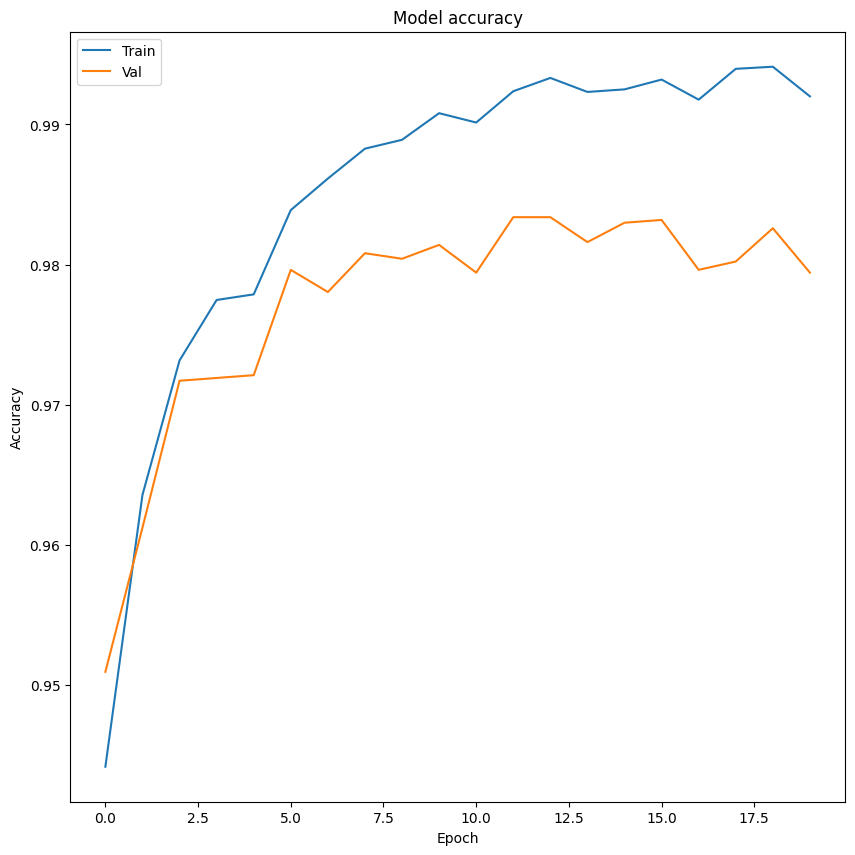

In [39]:
# Plot training and validation accuracy
plt.plot(train_accuracy_history)
plt.plot(valid_accuracy_history)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()